Last year, I kind of got a bee in my bonnet about trying to see if I could accurately (?) make small RF passives out of copper, rather than buying 2pF NP0 capacitors or something, as part of a long-on-the-horizon project to make extremely inexpensive GHz-class oscilloscope probes.  I figured that the right place to start was to fab out a board on JLCPCB's JLC04161H-3313 stackup with a handful of calibration standards, and some of the passives that I wanted to measure.  Then, I took it over to [Tom Verbeure](https://tomverbeure.github.io/)'s house, and we had a shootout trying to measure these passives with our varying test equipment -- he and his HP 8753C, and me and my NanoVNA.
<!-- TEASER_END --><toc></toc>
## Getting an accurate measurement of the DUT
### Previous results

The results were not great, but we didn't really know that yet.  Now that I just got a new Siglent SVA1032X, though (and a LibreCAL eCal!), I figured that I'd better revisit this.  When we last left our heroes, I had two versions of the board -- one finished with HASL, and one finished with ENIG.  And we had already discovered that some of the standards and DUTs were designed incorrectly, so we had made some changes to the boards with a knife.  Here's what the board looked like most recently.

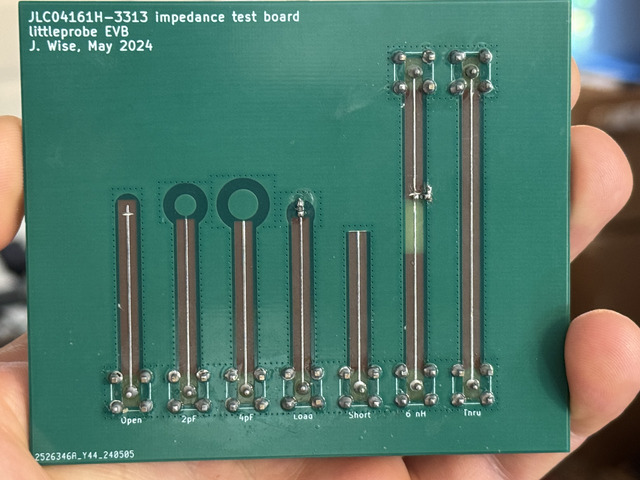

---

Let's focus on measurements taken of the HASL version, and of the 2pF DUT.

In [1]:
BOARD = "hasl"
DUT = "2pf"

I decided to try to figure out SciKit-RF for this application.

In [2]:
import matplotlib.pyplot as plt

import skrf
from skrf.media import DefinedGammaZ0, Coaxial
from skrf.calibration import OnePort

skrf.stylely()
%matplotlib inline
%config InlineBackend.figure_format='retina'

# This is the frequency space of my SVA1032X's measurements.
freq = skrf.Frequency(0.1, 3200, 1001, "MHz")
ideal_medium = DefinedGammaZ0(frequency = freq, z0 = 50)

First off, let's plot something that we saw last time.  Last time we did this, we used the ports on the board above as calibration standards.  We'll plot a Smith chart of the S11 of the 2pF DUT, as measured that way.  Hopefully, we will see a capacitor.

1-Port Network: 'hasl-2pf-hp8753c',  0.3-3000.0 MHz, 201 pts, z0=[50.+0.j]
1-Port Network: 'hasl-2pf-nanovna',  100000000.0-1500000112.0 Hz, 505 pts, z0=[50.+0.j]


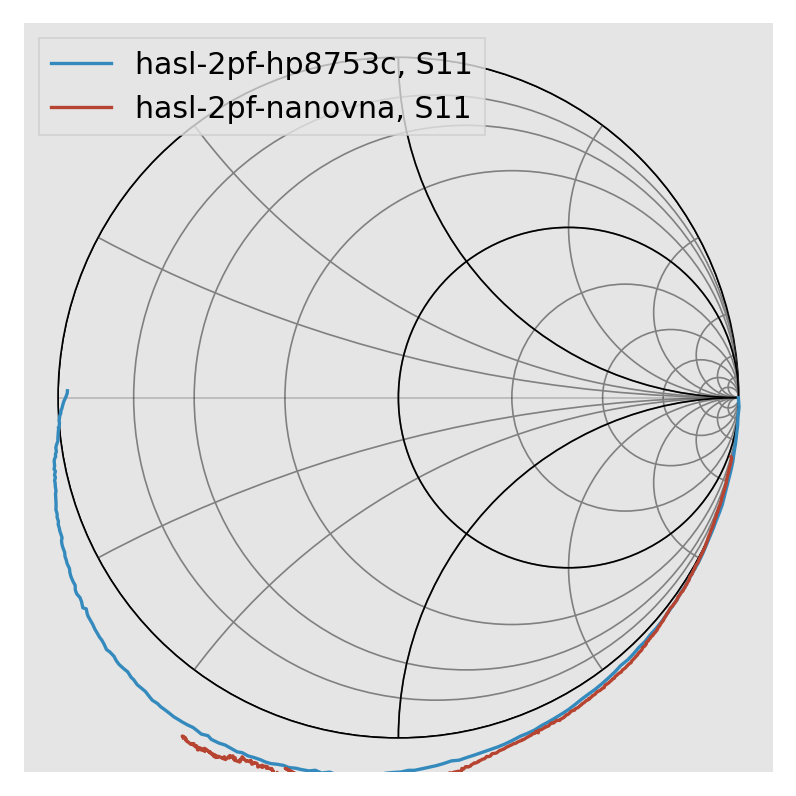

In [3]:
dut_hp8753c = skrf.Network(f'../{BOARD}-{DUT}-hp8753c.s1p')
dut_nanovna = skrf.Network(f'../{BOARD}-{DUT}-nanovna.s1p')

print(dut_hp8753c)
print(dut_nanovna)

dut_hp8753c.plot_s_smith()
dut_nanovna.plot_s_smith()

This is where we left off last time.  The 8753C and NanoVNA are broadly in agreement, and it looks capacitive, sort of, I guess, inasmuch as it rotates counterclockwise from an open.  But it doesn't seem right.  Notably, there is a S11 of greater than 0dB -- the S-parameters say that we get more energy back than we put in!

### New measurements on the SVA1032X

When I returned to this a year later, I measured with a different technique on my SVA1032X.  I defined my calibration plane to be the edge of the connectors, rather than trying to define it based on the edge of the DUT, which clearly was not working for some reason.  Here's what I measured with the calibration plane being the connector, for the DUT.

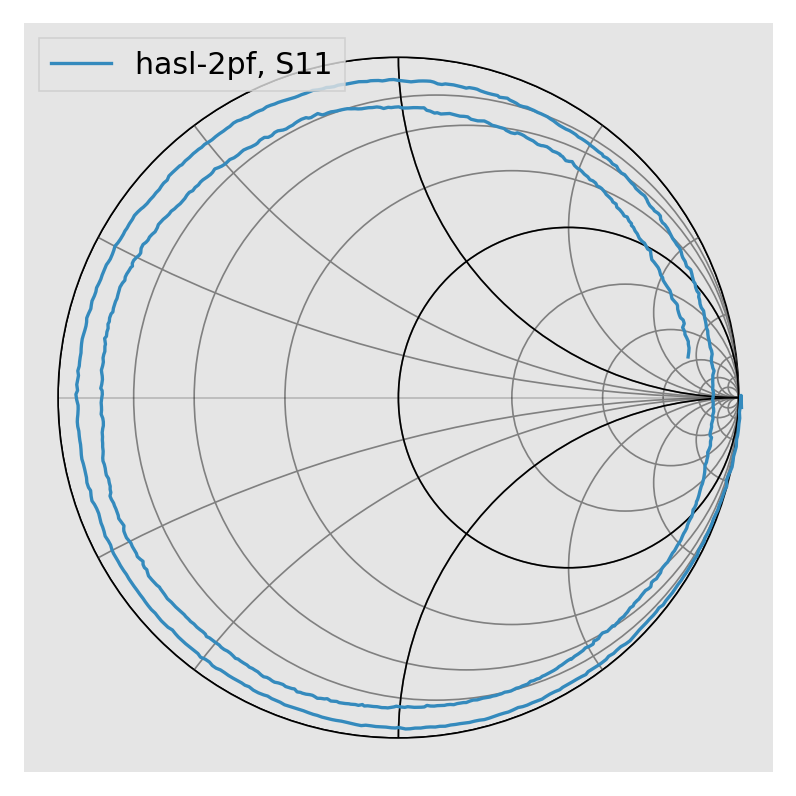

In [4]:
dut_meas = skrf.Network(f'{BOARD}-{DUT}.s1p')
dut_meas.plot_s_smith()

This makes a little more sense: the Smith chart is rotating around, which is an indication that there *is* a capacitor there, but there is a transmission line in series with it.  And it spirals inwards, which is an indication that there is some loss between our DUT and our calibration plane.

### Reproducing the old results with the new data

I also measured the S11 response of my open, short, and load "standards" at my new (arguably, more consistent and correct...) calibration plane.  Theoretically, I should be able to "calibrate" the above response to those in software, and it should look like what we measured a year ago.  Let's calibrate the new data to that, and then plot that and compare it against the previous result.

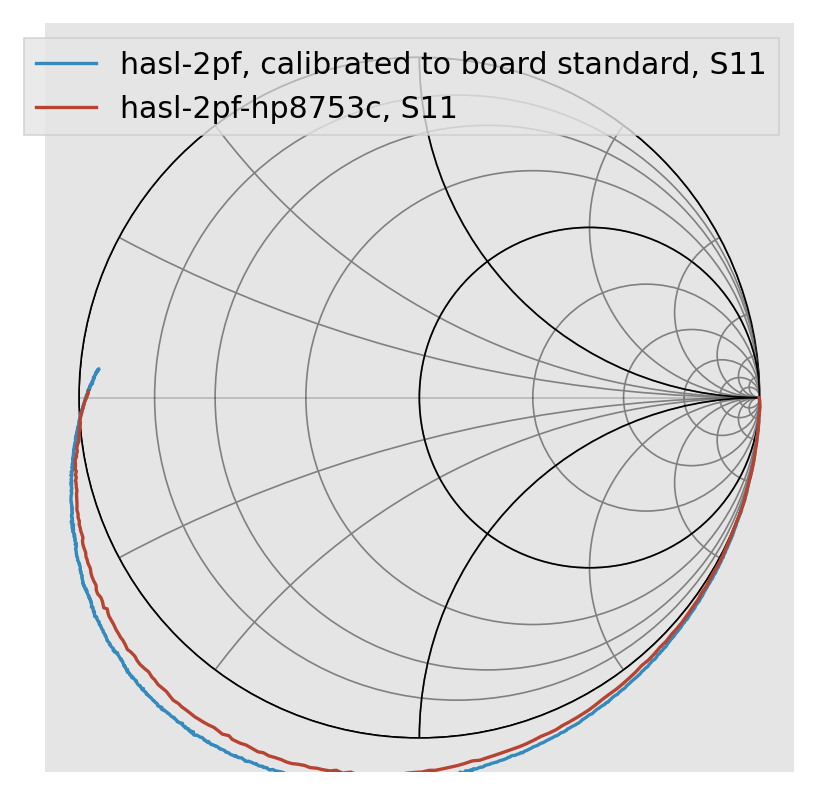

In [5]:
cal_boardstd = OnePort(
    ideals = [ ideal_medium.open(), ideal_medium.short(), ideal_medium.match() ],
    measured = [
        skrf.Network(f"{BOARD}-open.s1p"),
        skrf.Network(f"{BOARD}-short.s1p"),
        skrf.Network(f"{BOARD}-load.s1p"),
    ])
cal_boardstd.run()

dut_boardstd = cal_boardstd.apply_cal(dut_meas)
dut_boardstd.name = f"{BOARD}-{DUT}, calibrated to board standard"
dut_boardstd.plot_s_smith()
dut_hp8753c.plot_s_smith()

OK, this proves that I have at least enough of an understanding to replicate the incorrect thing that I did before using the Scikit-RF tools, rather than the on-device calibrations!  I guess if the desired behavior is to de-embed the transmission lines in the DUT, this, uh, re-embeds them, or something.  Anyway, the plots look consistent.

### Calibrating for port extensions

With my new VNA, I found a cool button on it labeled "port extensions".  My understanding is that it's good for when you're lazy and want to deembed a known length of ideal transmission line that you have attached to the end of your already-calibrated S11 measurement setup.  The results are not going to be perfect, because the transmission line you actually attached is not ideal (it has loss and its own reflections) -- but it does mean that you can get closer to measuring something that's on the other end.

When I tried this on the SVA1032X, I got a much nicer looking capacitive Smith chart!  Could I replicate this "port extension" behavior with the raw data in Scikit-RF?  My plan was that I would try to apply a calibration as if I had measured ideal standards a transmission line away.  That is to say, I was effectively relocating my calibration plane to be one piece of coax longer than it was originally measured to be.

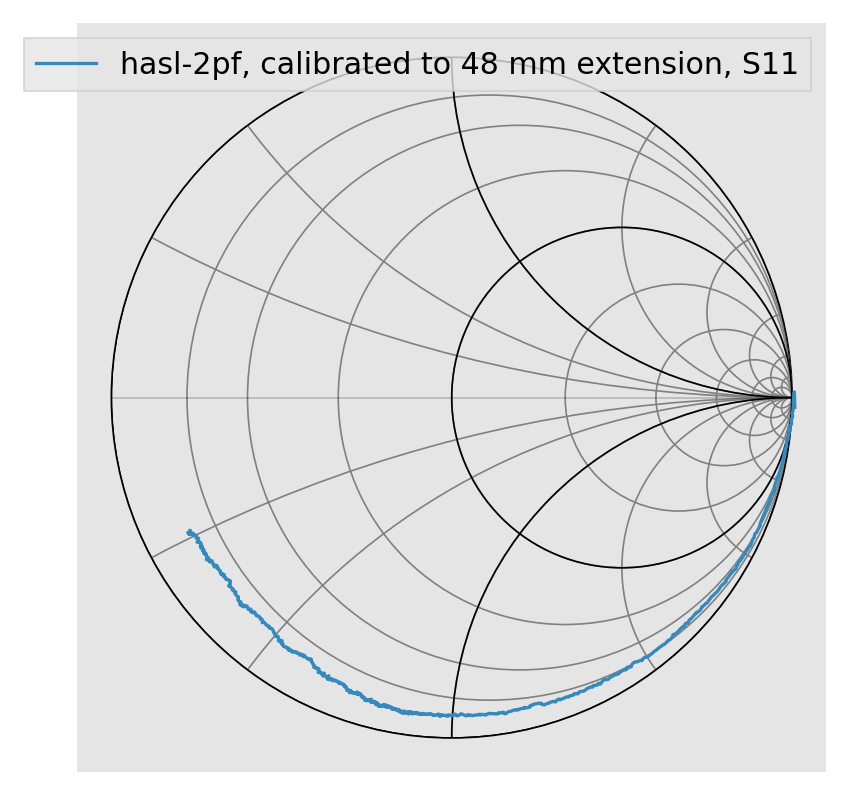

In [6]:
DIST = 48 #mm

lossy_medium = Coaxial(frequency=freq, z0_override=50, tan_delta = 0.03) # crummy FR4 board

cal_exten = OnePort(
    ideals = [ ideal_medium.open(), ideal_medium.short(), ideal_medium.match() ],
    measured = [
        lossy_medium.delay_open(DIST * 1000 / 0.66, 'um'),
        lossy_medium.delay_short(DIST * 1000 / 0.66, 'um'),
        ideal_medium.match(), # a distance-shifted match is still a match
    ]
)
cal_exten.run()

dut_exten = cal_exten.apply_cal(dut_meas)
dut_exten.name = f"{BOARD}-{DUT}, calibrated to {DIST} mm extension"
dut_exten.plot_s_smith()

These results looked a lot more like a capacitor!  And, importantly, they were not physically impossible.

One thing I realized as I was looking through the scikit-rf APIs is that there was an easier way to express what I meant: they have an easy mechanism to modify a network by [cascading it with another](https://scikit-rf.readthedocs.io/en/latest/tutorials/Networks.html#Cascading-and-De-embedding).  Since S-parameters are linear time-invariant functions, that also means that all S-parameters must have an inverse -- that is to say, if I have a transmission line on my desk that cascades certain S-parameters onto the front of some other network, then there *also* must be a set of S-parameters that I can cascade on the front that perfectly cancel out that transmission line's S-parameters.  (If you find that physical representation of an anti-transmission line, though, please let me know -- I'd like to have a few on my desk.)

In this case, I could take my `dut_meas` network, and cascade the *inverse* of my theorized perfect extension on the front, which they refer to as "de-embedding".  So I would take a model of this extension, invert it, and cascade it, and the Smith chart of the output ought be the same:

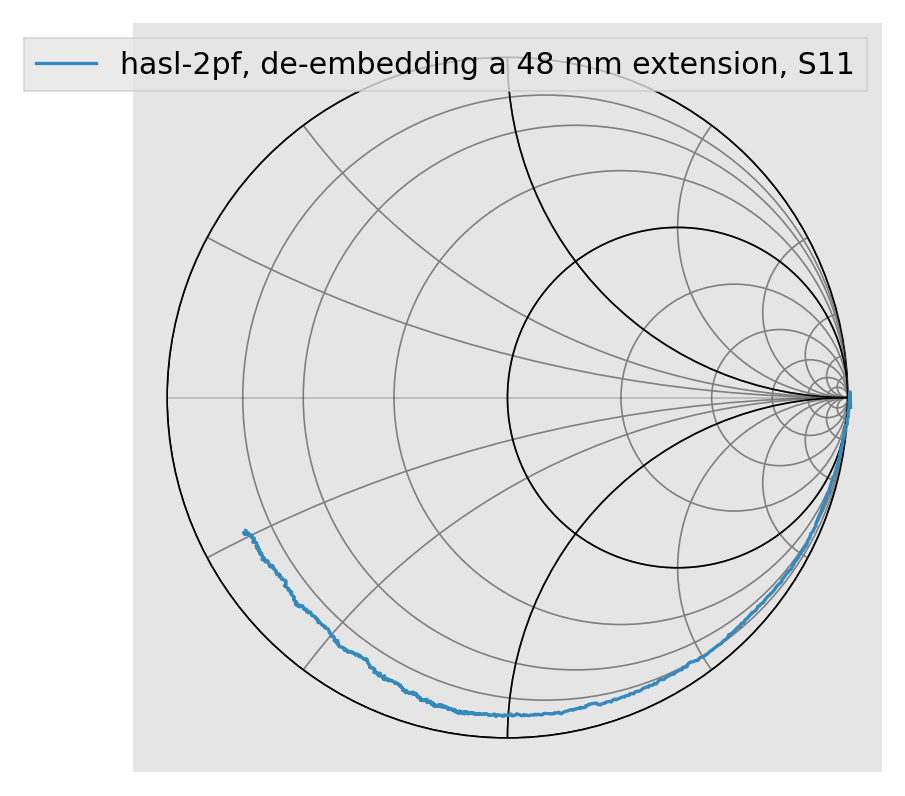

In [7]:
def mk_dist_mm(dist):
    return lossy_medium.line(dist * 1000 / 0.66, 'um')

dut_exten_2 = mk_dist_mm(DIST).inv ** dut_meas
dut_exten_2.name = f"{BOARD}-{DUT}, de-embedding a {DIST} mm extension"
dut_exten_2.plot_s_smith()

And indeed, it is.  That's a good trick to have in my back pocket.

### Deembedding the launch with poor quality standards

This looks pretty good, but one problem is that it includes the connector and the transmission line on the board.  We know that the amplitude response of our measurement trails off, but we don't know whether the amplitude response of the capacitor trails off, or whether that's an artifact of the launch.   Previously, we tried using the open / short / load standards on the board to deembed the connector launch and transmission line, but those gave very bizarre results.

When I played around with the port extension feature on the VNA, it became obvious why.  Even very small changes in length of the extension had a very large change in the Smith chart up in the 3GHz range.  Looking at the board, the standards on the board do not have a consistent length!  Could this cause the extremely strange looking S11 plot that I was seeing last year?

With my new knowledge of calibrating things out, I realized that I could potentially "fix" the calibration standards.  I knew that the calibration standards were probably fine, except for the fact that they were unusual lengths.  If I included the lengths in the definition of the calibration standard, then I could probably move the calibration plane (or, well, an approximation thereof) right up to the edge of my DUT.

Looking at the board, it looks like the place where we cut the open is around 1.5-2 mm longer than the edge of the capacitor; the load is similarly far away; and the short is 2.5-2.8mm or so too... short.  If I cascade these lines (or these anti-lines) with the definition of my calibration ideals, I should be able to calibrate these out.  Let's try it:

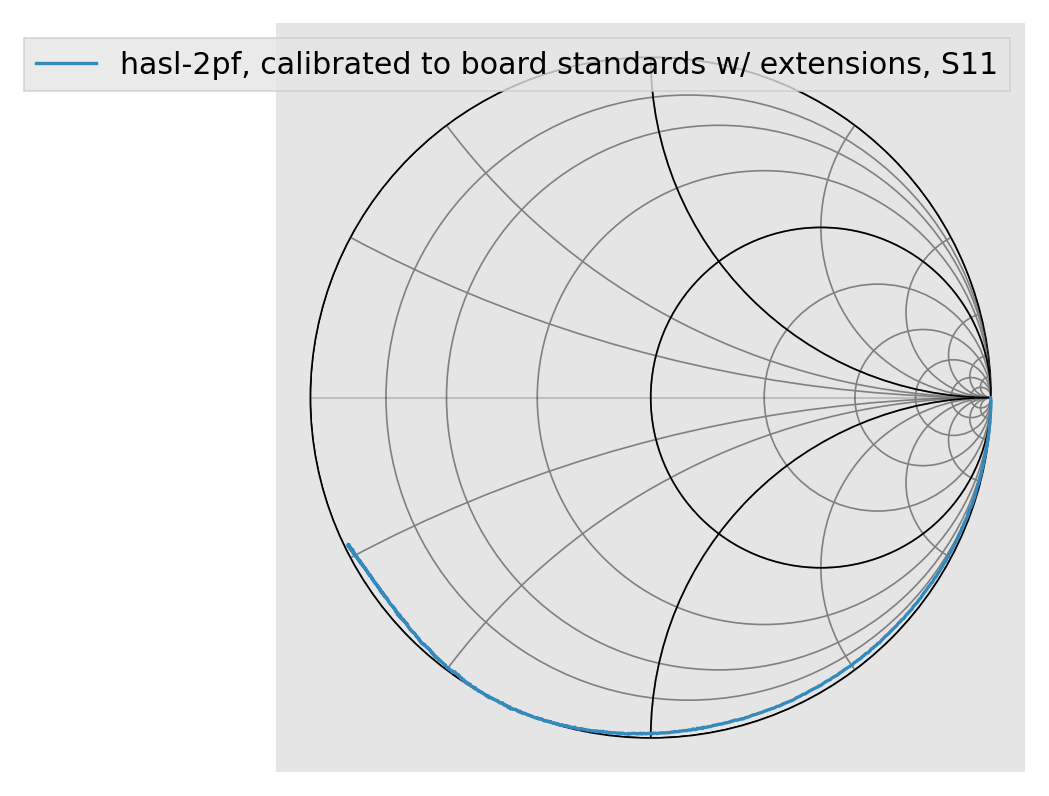

In [8]:
cal_boardstd_ext = OnePort(
    ideals = [
        mk_dist_mm(1.6)     ** ideal_medium.open(),
        mk_dist_mm(2.7).inv ** ideal_medium.short(),
        mk_dist_mm(1.6)     ** ideal_medium.match() # which is the same as a match unmodified, but...
    ], measured = [
        skrf.Network(f"{BOARD}-open.s1p"),
        skrf.Network(f"{BOARD}-short.s1p"),
        skrf.Network(f"{BOARD}-load.s1p"),
    ])
cal_boardstd_ext.run()

dut_boardstd_ext = cal_boardstd_ext.apply_cal(dut_meas)
dut_boardstd_ext.write_touchstone(f"{BOARD}-{DUT}-boardstd_ext")
dut_boardstd_ext.name = f"{BOARD}-{DUT}, calibrated to board standards w/ extensions"
dut_boardstd_ext.plot_s_smith()

Now *that*, at last, looks like a capacitor.

## How capacitor is capacitor?

One of the original goals of this experiment was to know whether I had made a capacitor -- and, if so, how good of a capacitor, and what the value of the capacitor was.  A year ago, we just sampled a handful of points on the curve and asked the VNA tool what it thought the capacitance at each point was, and I think we took this as gospel and just chose a point that seemed right.

How it does this underneath is by computing the S-parameters to $latex Z$-parameters, and converting the complex impedance to a combination of a real impedance and either an inductor or capacitor.  We can do this because a capacitor's impedance, $latex Z_C$ at a given frequency $latex \omega$ is defined as:

$$Z_{C} = - \frac{j}{\omega C}$$

This means that at every frequency, a capacitor's imaginary impedance ought always be negative, and its real impedance ought always be zero -- if it's a good capacitor, that is.

Given that we have this all numerically represented in... a computer... we can convert the S-parameters to $latex Z$-parameters, and plot them, hopefully.  When we tried to do this a year ago, we had some extremely surprising data.  (Since these plots are logarithmic, dotted regions indicate negative values, which could not otherwise be represented.)

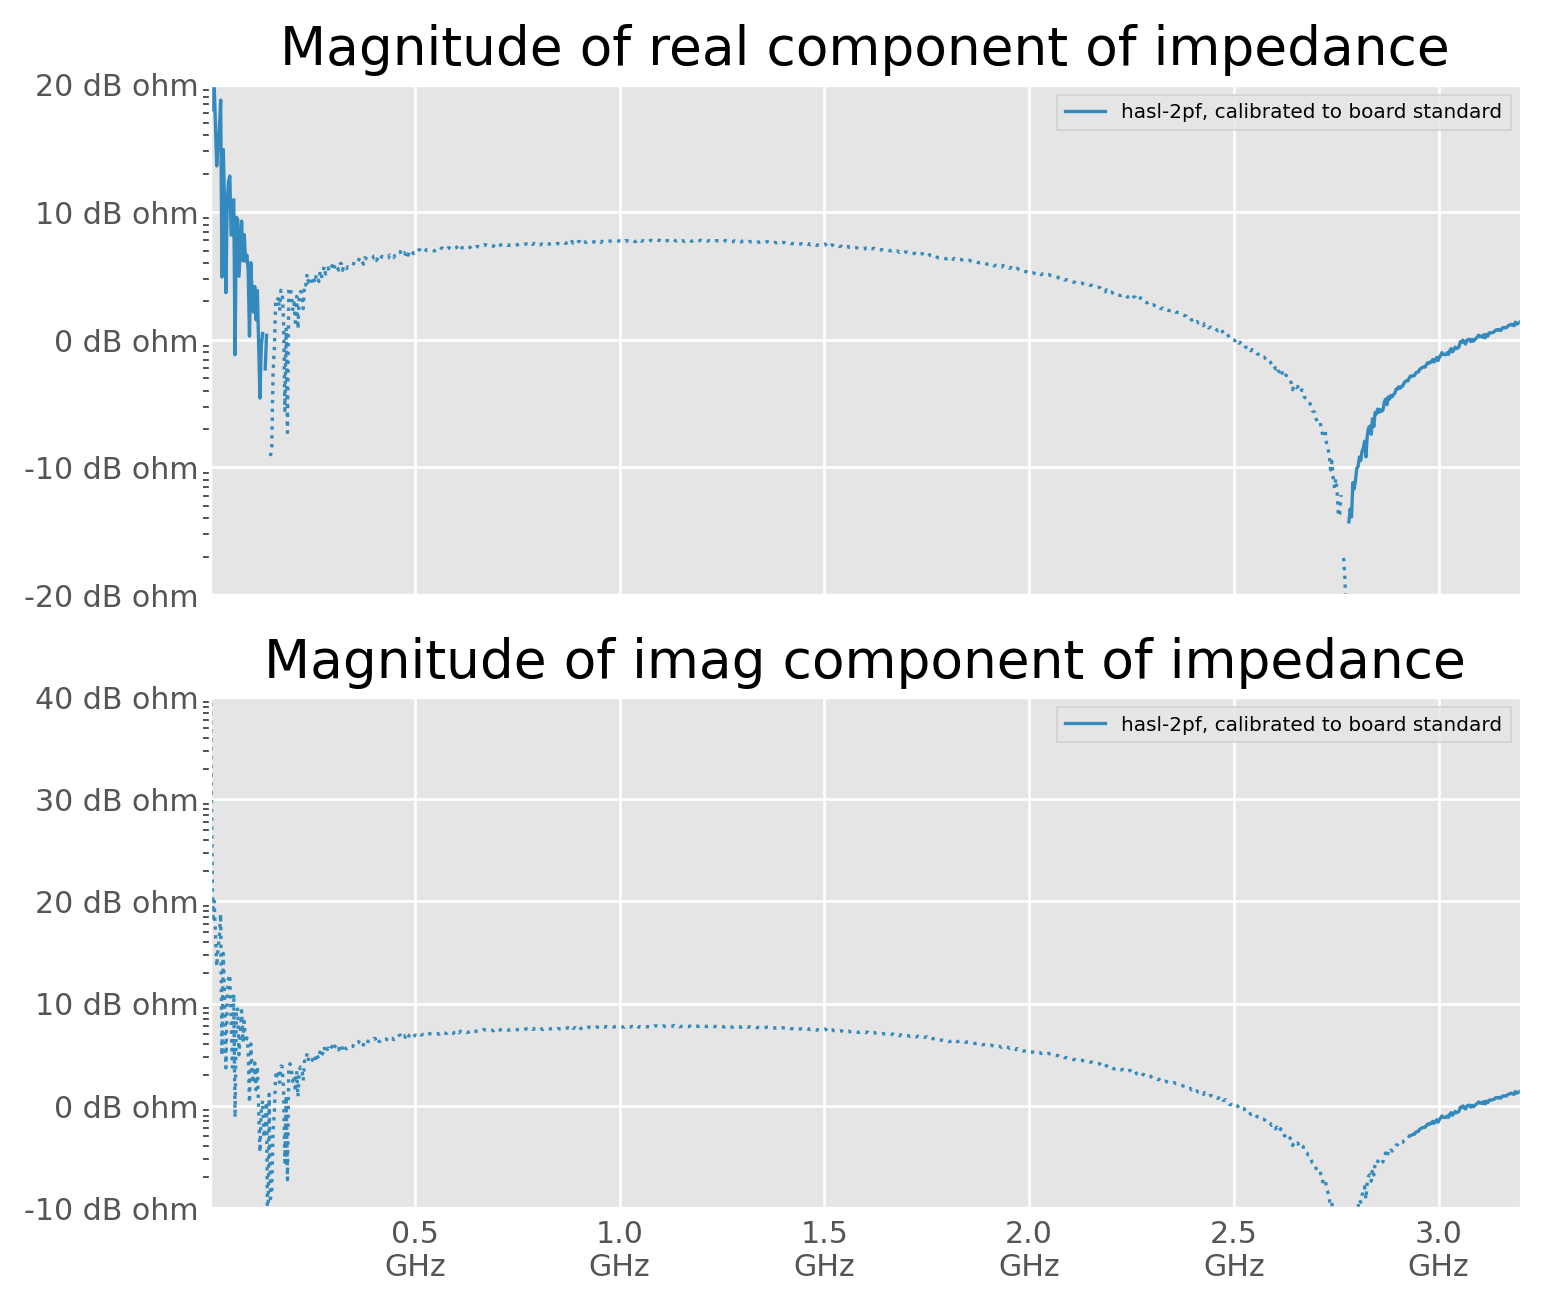

In [9]:
import math
import numpy as np

def plot_re_mag(ax, dut_plot):
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(dut_plot.f, np.where(dut_plot.z_re[:, 0, 0] < 0, np.nan, abs(dut_plot.z_re[:,0,0])), color=color, label=dut_plot.name)
    ax.plot(dut_plot.f, np.where(dut_plot.z_re[:, 0, 0] > 0, np.nan, abs(dut_plot.z_re[:,0,0])), ':', color=color)
    ax.set_ylim(0.01,100)
    ax.set_yscale("log")
    ax.set_title("Magnitude of real component of impedance")
    ax.yaxis.set_major_formatter(lambda y,pos: f"{10 * math.log10(y):.0f} dB ohm")
    ax.legend(loc="upper right", fontsize=6)
    ax.xaxis.set_major_formatter(lambda y,pos: f"{y/1e9:.1f}\nGHz")

def plot_im_mag(ax, dut_plot):
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(dut_plot.f, np.where(dut_plot.z_im[:, 0, 0] < 0, np.nan, abs(dut_plot.z_re[:,0,0])), color=color, label=dut_plot.name)
    ax.plot(dut_plot.f, np.where(dut_plot.z_im[:, 0, 0] > 0, np.nan, abs(dut_plot.z_re[:,0,0])), ':', color=color)
    ax.set_ylim(0.1,10000)
    ax.set_yscale("log")
    ax.set_title("Magnitude of imag component of impedance")
    ax.yaxis.set_major_formatter(lambda y,pos: f"{10 * math.log10(y):.0f} dB ohm")
    ax.legend(loc="upper right", fontsize=6)
    ax.xaxis.set_major_formatter(lambda y,pos: f"{y/1e9:.1f}\nGHz")

fig,(ax0, ax1) = plt.subplots(2,1, sharex = True, figsize=(7,6))
plot_re_mag(ax0, dut_boardstd)
plot_im_mag(ax1, dut_boardstd)

### Measuring capacitance, instead of magnitude
This is a little bit hard to understand, looking just at the imaginary component of impedance, since really it needs to be normalized to frequency.  The real component, though, we definitely see something strange here: it ought be extremely close to 0, and it definitely is not.  That is to say, it should be well in the -many dB ohm range.  What if we replot the imaginary component as the effective capacitance, though?  We know that

$$Z_{C} = -j \frac{1}{\omega * C}$$

So we should be able to rephrase this as:

$$C = - \frac{1}{\textrm{Im}(Z_{C})*2*\pi*f}$$

We're hoping this is going to be around 2 pF.  So let's plot around the picofarad scale.

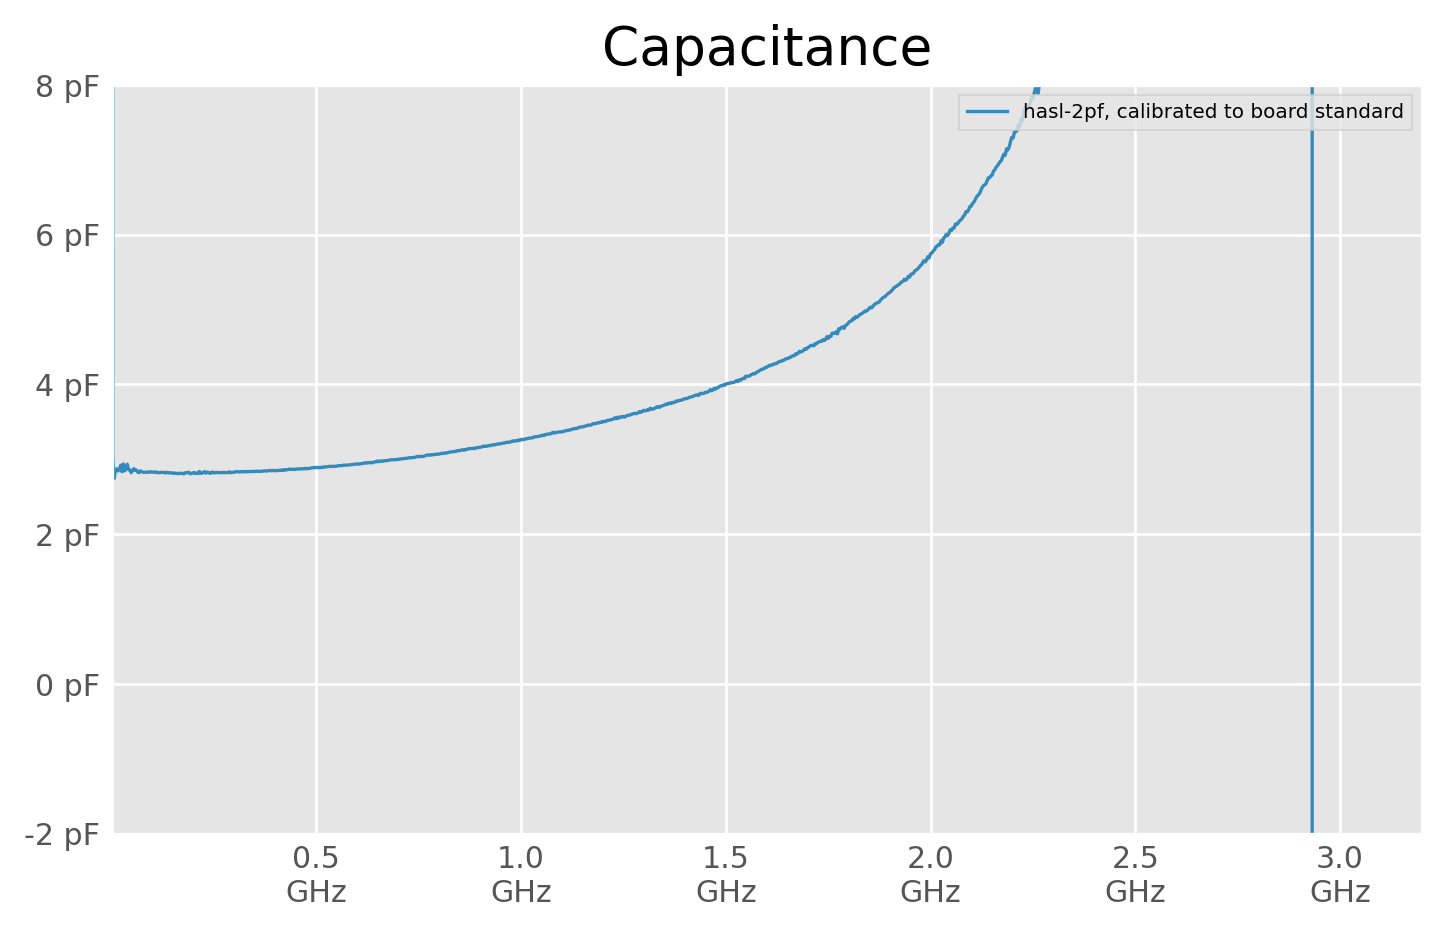

In [10]:
def plot_cap(ax, dut_plot):
    ax.plot(dut_plot.f, -1/(dut_plot.z_im[:,0,0] * 2*math.pi*dut_plot.f), label=dut_plot.name)
    ax.set_ylim(-2e-12, 8e-12)
    ax.set_title("Capacitance")
    ax.yaxis.set_major_formatter(lambda y,pos: f"{y/1e-12:.0f} pF")
    ax.xaxis.set_major_formatter(lambda y,pos: f"{y/1e9:.1f}\nGHz")
    ax.legend(loc="upper right", fontsize=6)
    
fig,ax = plt.subplots(1,1, sharex = True, figsize=(7,4))
plot_cap(ax, dut_boardstd)

### At long last, measuring a capacitor (I hope)
This is close!  But it goes completely wrong at high frequency -- in fact, into negative capacitance.  That can't be right.  Now let's take a look at the version with our calibration recovery tactics.

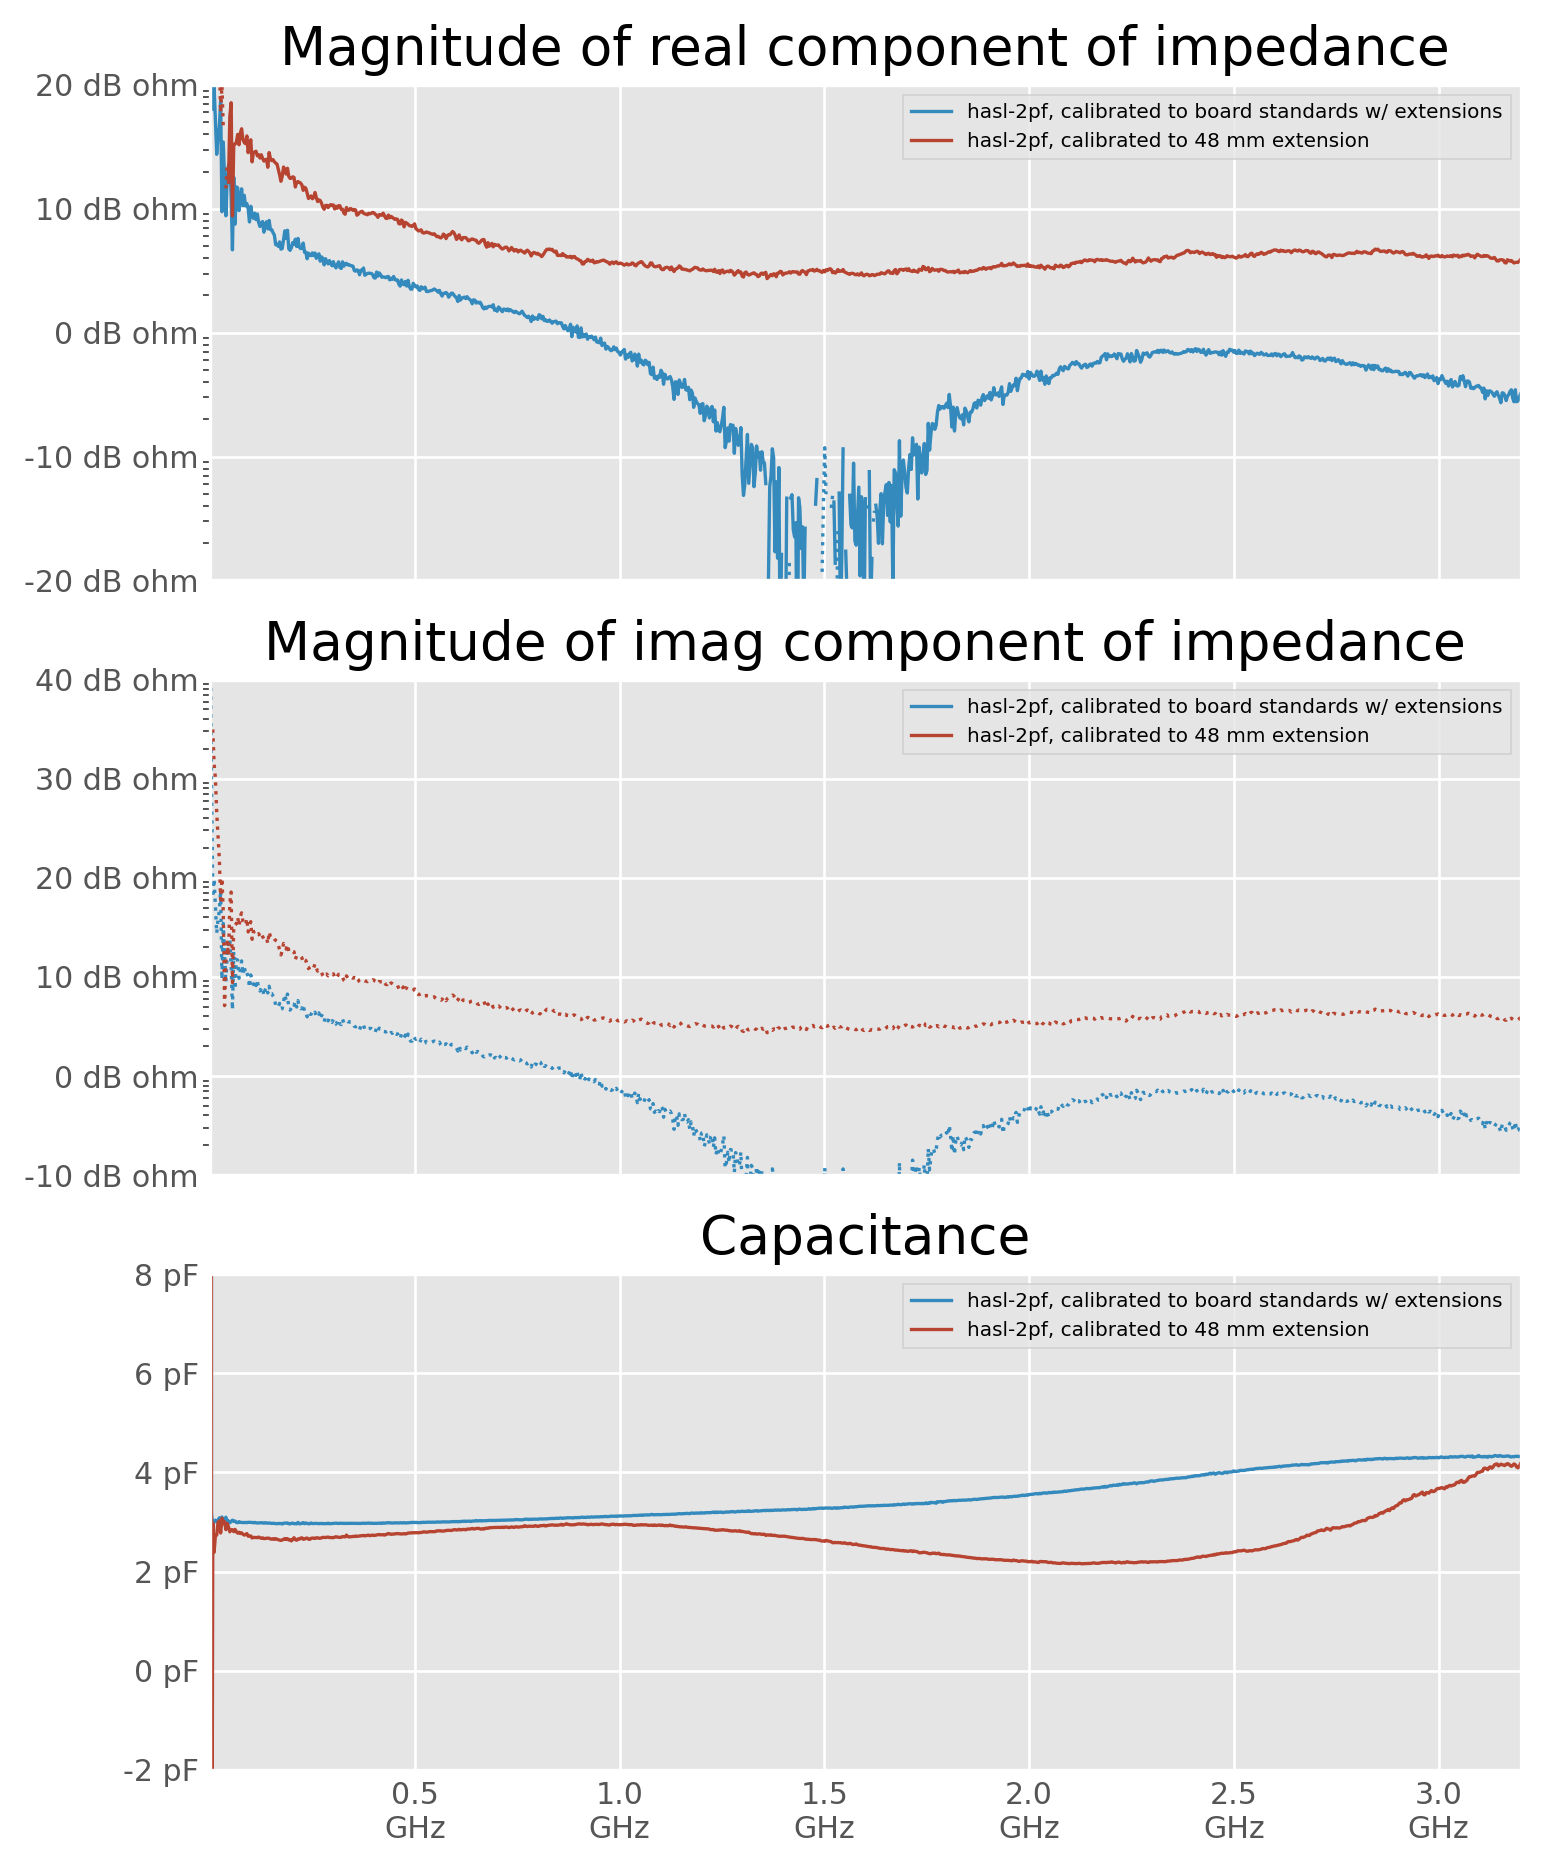

In [11]:
fig,(ax0, ax1, ax2) = plt.subplots(3,1, sharex = True, figsize=(7,9))
plot_re_mag(ax0, dut_boardstd_ext)
plot_re_mag(ax0, dut_exten)
plot_im_mag(ax1, dut_boardstd_ext)
plot_im_mag(ax1, dut_exten)
plot_cap(ax2, dut_boardstd_ext)
plot_cap(ax2, dut_exten)

Both traces look prety plausible.  It's hard to tell which one is actually "right" -- since FR4's $latex D_K$ reduces with frequency, we should expect that the capacitance should also lower with frequency, which the simple extension calibration (red trace) shows, and the extended board standard calibration (blue trace) shows the opposite of.

On the *other* hand, we should expect there to be more error of some kind that I can't intuitively seem to predict in the red trace than the blue trace, because it would not compensate for the fact that the characteristic impedance of the transmission line would also change with frequency, whereas the blue trace should compensate for that.

But for now, I think I've met my objective a fair bit more closely than I did before.  This looks a *lot* more like a capacitor, both on the Smith chart and by looking at the $latex Z$-parameters.  I think to *really* be able to characterize this capacitor, I would need to do a better job of designing my test fixture.  But, more to the point, now I have a much better understanding of what I'm actually doing when I calibrate, and what kinds of questions it's even possible to ask of a set of S-parameters.

---

J. Wise, June 2025

## Appendices: other DUTs

I wrote all these words and then I realized that there are two other DUTs on my board, and it's probably worth characterizing those too!  So let's plot some of those.  
### 4pF capacitor
First off, there's the 4pF DUT.  Hopefully that should be twice the capacitance of the 2pF DUT.

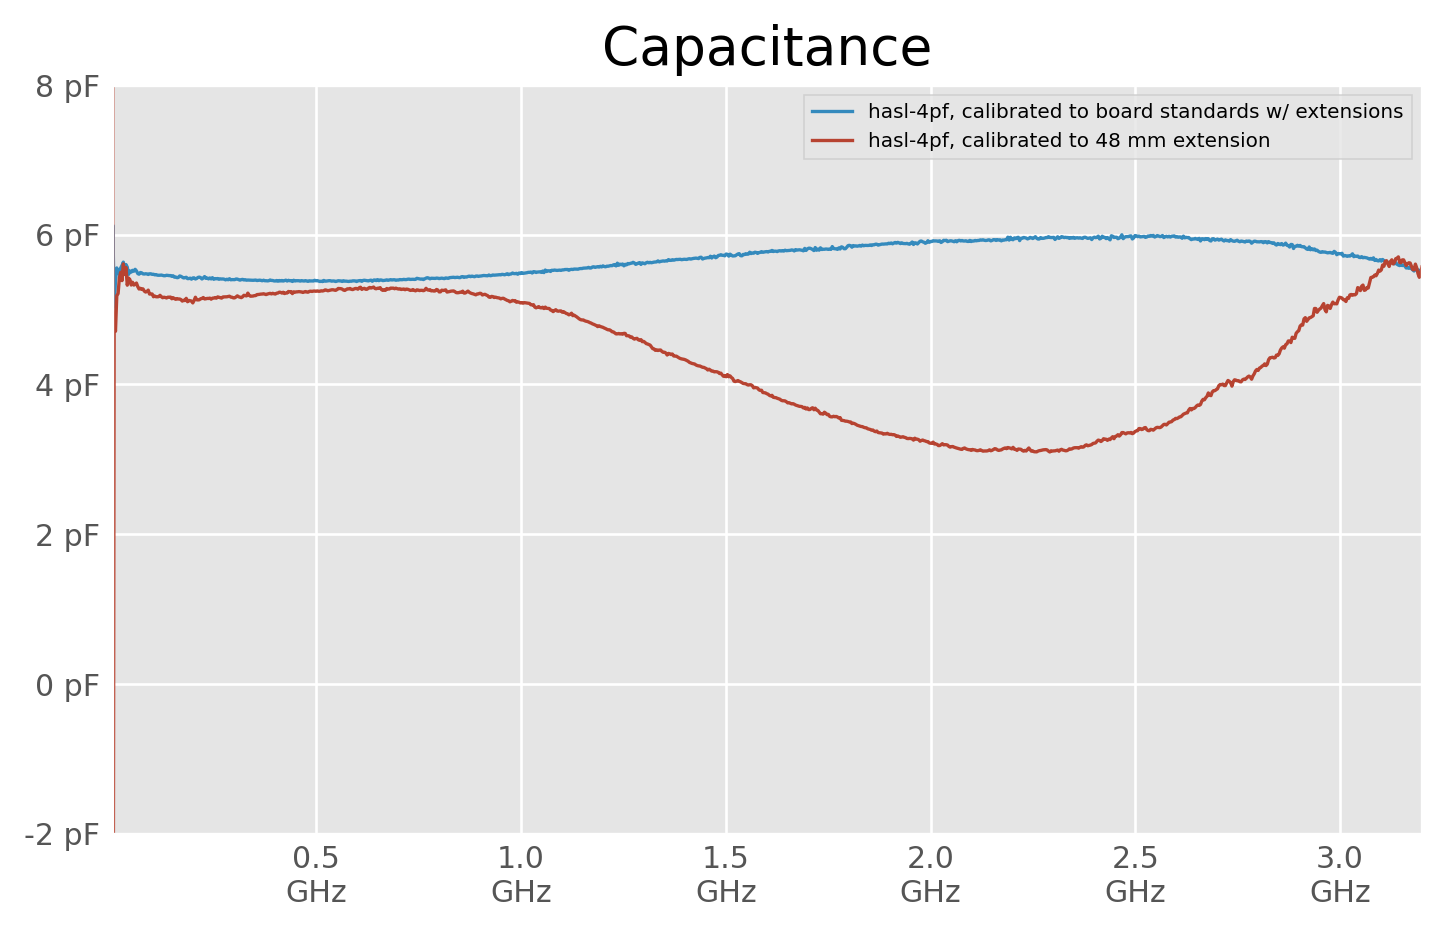

In [12]:
dut_4pf = skrf.Network(f'{BOARD}-4pf.s1p')
dut_4pf_exten        = cal_exten       .apply_cal(dut_4pf)
dut_4pf_boardstd_ext = cal_boardstd_ext.apply_cal(dut_4pf)
dut_4pf_exten.name        += f", calibrated to {DIST} mm extension"
dut_4pf_boardstd_ext.name += ", calibrated to board standards w/ extensions"

fig,ax = plt.subplots(1,1, sharex = True, figsize=(7,4))
plot_cap(ax, dut_4pf_boardstd_ext)
plot_cap(ax, dut_4pf_exten)

Interestingly, the dip effect of the extension is even greater in this test, while the rise from the calibrated-to-board-standards version is about constant in terms of total capacitance.  Why is that?

### 6nH inductor
This one is pretty similar, except, of course, for the fact that inductance is positive.  The impedance of an inductor is represented as:

$$Z_L = j\omega{}L$$

So we can hopefully calculate the inductance with:

$$L = \frac{\textrm{Im}(Z_{L})}{2*\pi*f}$$

For some reason, I moved the inductor about 8mm south.  Why did I do that?  I have no idea, but now we have to compensate for it.

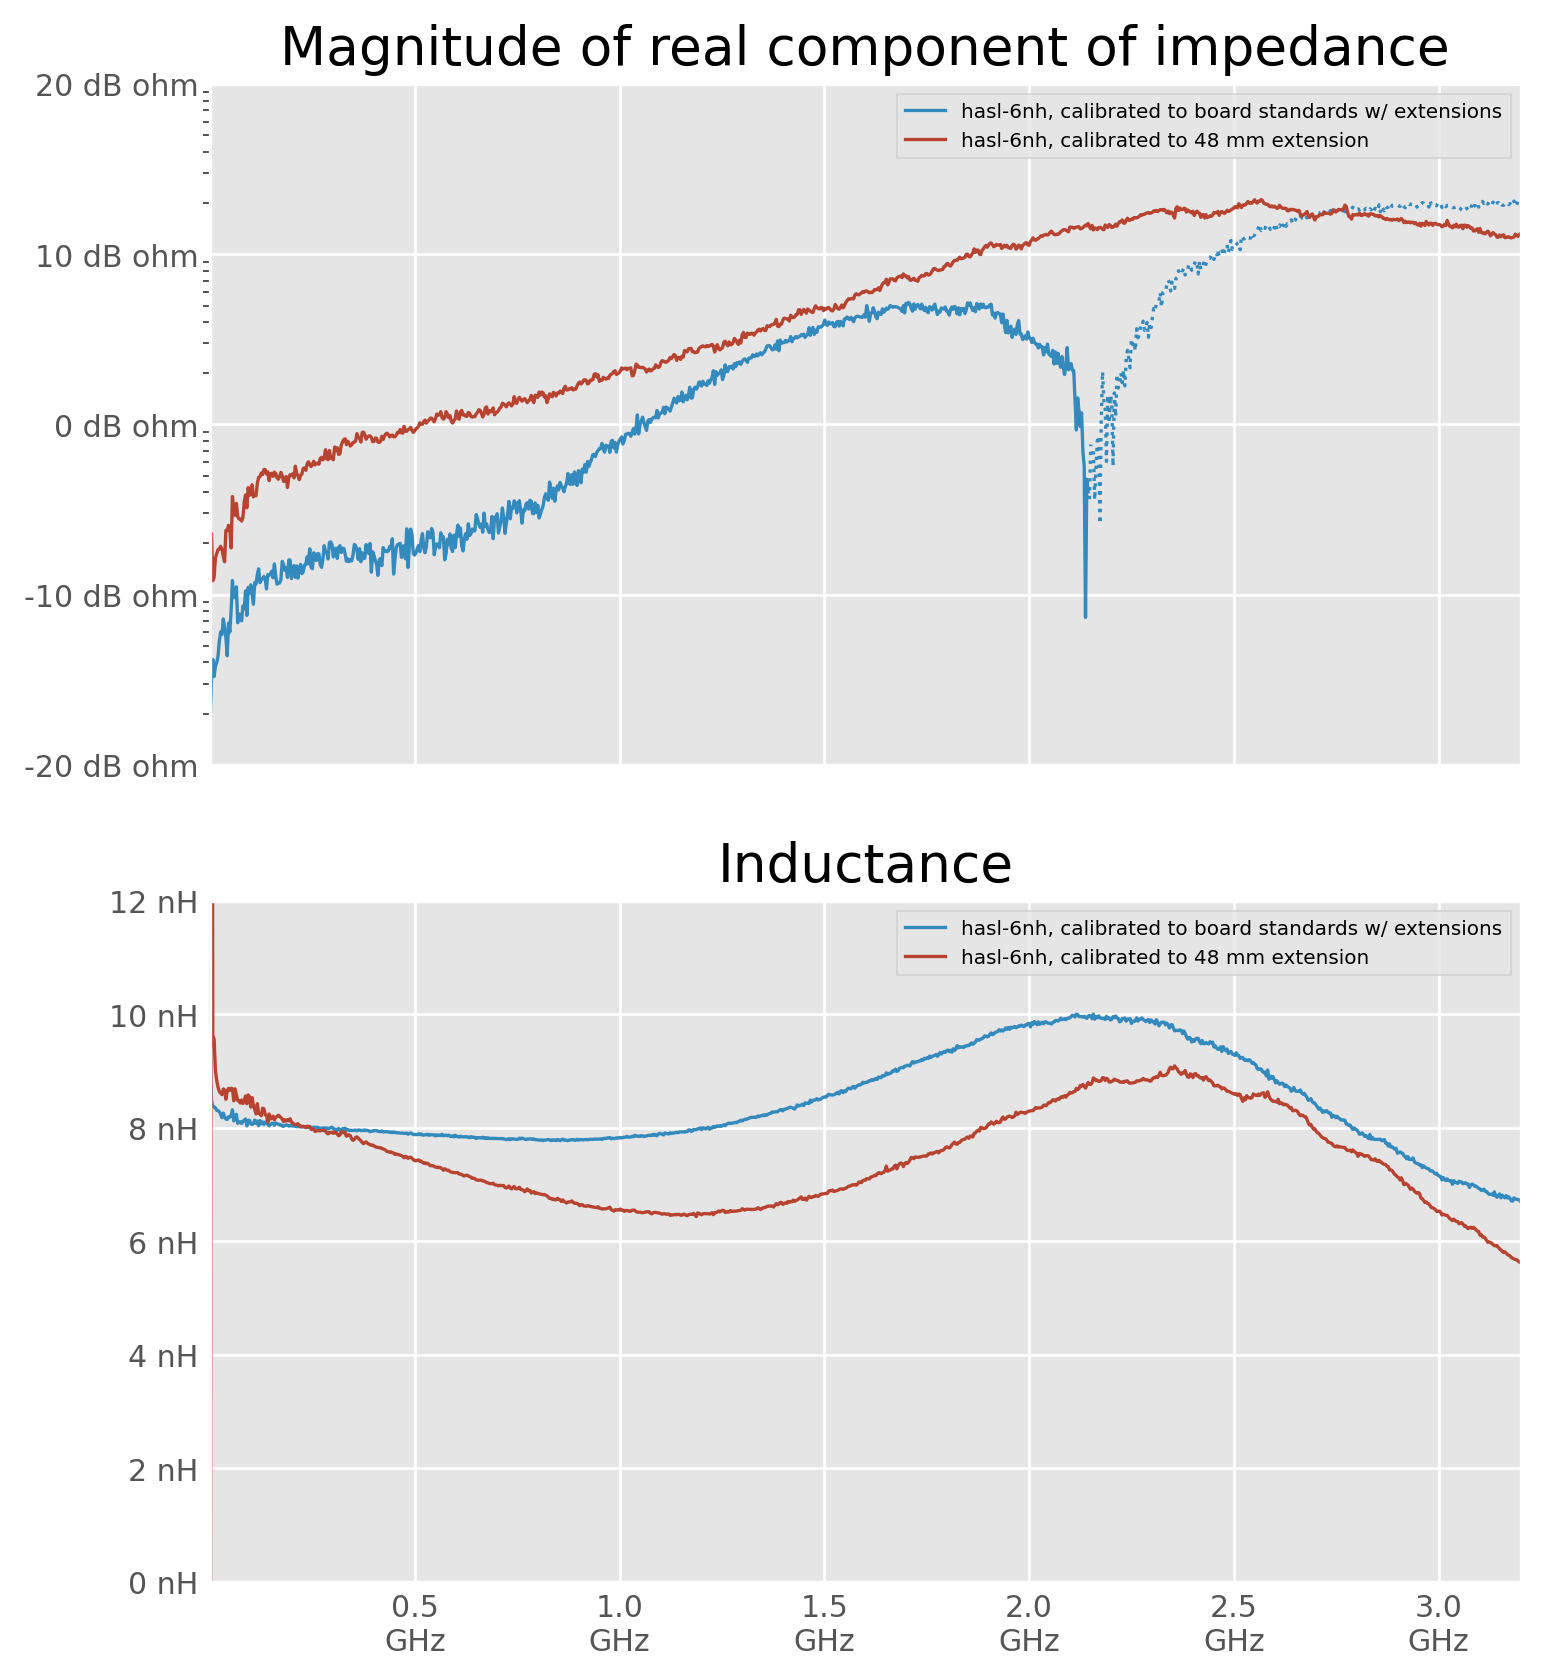

In [13]:
def plot_ind(ax, dut_plot):
    ax.plot(dut_plot.f, dut_plot.z_im[:,0,0]/(2*math.pi*dut_plot.f), label=dut_plot.name)
    ax.set_ylim(0, 12e-9)
    ax.set_title("Inductance")
    ax.yaxis.set_major_formatter(lambda y,pos: f"{y/1e-9:.0f} nH")
    ax.xaxis.set_major_formatter(lambda y,pos: f"{y/1e9:.1f}\nGHz")
    ax.legend(loc="upper right", fontsize=6)

dut_6nh = skrf.Network(f'{BOARD}-6nh.s1p')
dut_6nh_exten        = cal_exten       .apply_cal(dut_6nh)
dut_6nh_boardstd_ext = cal_boardstd_ext.apply_cal(dut_6nh)
dut_6nh_exten.name        += f", calibrated to {DIST} mm extension"
dut_6nh_boardstd_ext.name += ", calibrated to board standards w/ extensions"

dut_6nh_exten_moved = mk_dist_mm(7) ** dut_6nh_exten
dut_6nh_exten_moved.name = dut_6nh_exten.name

dut_6nh_boardstd_ext_moved = mk_dist_mm(7) ** dut_6nh_boardstd_ext
dut_6nh_boardstd_ext_moved.name = dut_6nh_boardstd_ext.name

fig,(ax0,ax1) = plt.subplots(2,1, sharex = True, figsize=(7,8))
plot_re_mag(ax0, dut_6nh_boardstd_ext_moved)
plot_re_mag(ax0, dut_6nh_exten_moved)
plot_ind(ax1, dut_6nh_boardstd_ext_moved)
plot_ind(ax1, dut_6nh_exten_moved)

It is not super duper flat, and basically the best argument that this provides is that I ought redesign the board with better standards, and measure.  But it is pretty close to the rough back-of-envelope calculations from when I designed it, so I think I'm OK with that!